Shape of X_train_raw: (500, 2)
Shape of y_train_raw: (500,)
Shape of X_test_02: (500, 2)
Shape of X_test_01: (500, 2)
Shape of X_test_03: (500, 2)


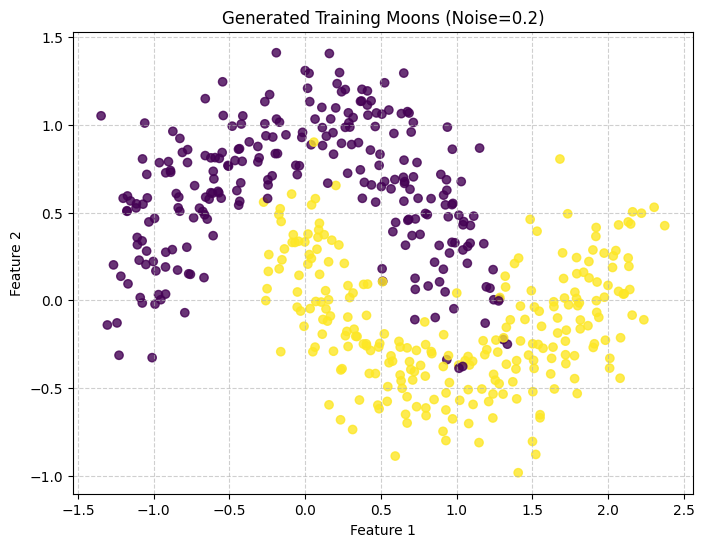

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Set the global random seed for reproducibility
np.random.seed(1337)

def make_my_moons(n_samples, noise=0.2):
    """
    Generates a 'make_moons' dataset from scratch.
    """
    n_samples_per_moon = n_samples // 2

    # Generate angles from 0 to pi
    t = np.linspace(0, np.pi, n_samples_per_moon)

    # Create the top moon (class 0)
    x1 = np.cos(t)
    y1 = np.sin(t)

    # Create the bottom moon (class 1)
    # We shift it 1 unit right and 0.5 units down
    x2 = 1 - np.cos(t)
    y2 = 0.5 - np.sin(t)

    # Combine the moons
    X = np.vstack([
        np.column_stack([x1, y1]),
        np.column_stack([x2, y2])
    ])

    y = np.hstack([
        np.zeros(n_samples_per_moon),
        np.ones(n_samples_per_moon)
    ])

    # Add Gaussian noise
    noise_vals = np.random.normal(0, noise, X.shape)
    X += noise_vals

    # Shuffle the dataset
    indices = np.arange(n_samples)
    np.random.shuffle(indices)

    return X[indices], y[indices]

# --- 1. Generate all required datasets ---

# Training set (n=500, noise=0.2)
X_train_raw, y_train_raw = make_my_moons(n_samples=500, noise=0.2)

# Test set 1 (n=500, noise=0.2)
X_test_02, y_test_02 = make_my_moons(n_samples=500, noise=0.2)

# Test set 2 (n=500, noise=0.1)
X_test_01, y_test_01 = make_my_moons(n_samples=500, noise=0.1)

# Test set 3 (n=500, noise=0.3)
X_test_03, y_test_03 = make_my_moons(n_samples=500, noise=0.3)

print(f"Shape of X_train_raw: {X_train_raw.shape}")
print(f"Shape of y_train_raw: {y_train_raw.shape}")
print(f"Shape of X_test_02: {X_test_02.shape}")
print(f"Shape of X_test_01: {X_test_01.shape}")
print(f"Shape of X_test_03: {X_test_03.shape}")

# --- 2. Visualize the training data to confirm ---
plt.figure(figsize=(8, 6))
plt.scatter(X_train_raw[:, 0], X_train_raw[:, 1], c=y_train_raw, cmap='viridis', alpha=0.8)
plt.title("Generated Training Moons (Noise=0.2)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [ ]:
# --- 3. Create a validation split (20% of the training data) ---
# We use train_test_split on the raw training data
X_train, X_val, y_train, y_val = train_test_split(
    X_train_raw,
    y_train_raw,
    test_size=0.20,
    random_state=1337
)

print(f"Original training shape: {X_train_raw.shape}")
print(f"New training shape (X_train): {X_train.shape}")
print(f"Validation shape (X_val): {X_val.shape}")
print("-" * 30)

# --- 4. Standardize all datasets using ONLY train statistics ---
scaler = StandardScaler()

# Fit the scaler ONLY on the training data
scaler.fit(X_train)

# Transform all datasets
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

X_test_01_scaled = scaler.transform(X_test_01)
X_test_02_scaled = scaler.transform(X_test_02)
X_test_03_scaled = scaler.transform(X_test_03)

# Let's check the mean and std of our new scaled training data
print(f"Scaled X_train mean (approx 0): {X_train_scaled.mean(axis=0)}")
print(f"Scaled X_train std (approx 1): {X_train_scaled.std(axis=0)}")

# Check the mean of a test set (should NOT be 0)
print(f"Scaled X_test_02 mean (not 0): {X_test_02_scaled.mean(axis=0)}")

Original training shape: (500, 2)
New training shape (X_train): (400, 2)
Validation shape (X_val): (100, 2)
------------------------------
Scaled X_train mean (approx 0): [-2.02615702e-16 -2.30648833e-16]
Scaled X_train std (approx 1): [1. 1.]
Scaled X_test_02 mean (not 0): [ 0.01400796 -0.01104559]


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score, accuracy_score
import copy

# Set PyTorch seed for reproducibility
torch.manual_seed(1337)
torch.cuda.manual_seed_all(1337) # if you're using GPU

# --- 5. Convert data to PyTorch Tensors ---
# We need y to be in the shape [n_samples, 1] for BCEWithLogitsLoss
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)

X_val_t = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32).reshape(-1, 1)

# We'll also convert the test sets now for later
X_test_01_t = torch.tensor(X_test_01_scaled, dtype=torch.float32)
y_test_01_t = torch.tensor(y_test_01, dtype=torch.float32).reshape(-1, 1)
X_test_02_t = torch.tensor(X_test_02_scaled, dtype=torch.float32)
y_test_02_t = torch.tensor(y_test_02, dtype=torch.float32).reshape(-1, 1)
X_test_03_t = torch.tensor(X_test_03_scaled, dtype=torch.float32)
y_test_03_t = torch.tensor(y_test_03, dtype=torch.float32).reshape(-1, 1)

# --- 6. Create DataLoaders ---
BATCH_SIZE = 64
train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = TensorDataset(X_val_t, y_val_t)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- 7. Define the MLP Model ---
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x

# --- 8. Define the EarlyStopping Class (Corrected) ---
class EarlyStopping:
    def __init__(self, patience=50, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf  # <-- This is the corrected line
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# --- 9. Initialize Model, Loss, Optimizer ---
INPUT_SIZE = X_train_t.shape[1]
HIDDEN_SIZE = 32 # We can tune this, but 32 is a good start
OUTPUT_SIZE = 1

model_1_early_stopping = MLP(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)
criterion = nn.BCEWithLogitsLoss() # Handles sigmoid internally
optimizer = optim.Adam(model_1_early_stopping.parameters(), lr=0.01)

# --- 10. Training Loop with Early Stopping ---
N_EPOCHS = 1000
PATIENCE = 50
CHECKPOINT_PATH = 'model_1_checkpoint.pt'

early_stopper = EarlyStopping(patience=PATIENCE, verbose=False, path=CHECKPOINT_PATH)

print("Starting training for Model 1 (MLP with Early Stopping)...")

for epoch in range(1, N_EPOCHS + 1):
    # --- Training Phase ---
    model_1_early_stopping.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model_1_early_stopping(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)

    # --- Validation Phase ---
    model_1_early_stopping.eval()
    val_loss = 0.0
    val_preds = []
    val_targets = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model_1_early_stopping(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)

            # Store predictions (as probabilities) and targets for AUROC
            val_preds.extend(torch.sigmoid(outputs).cpu().numpy())
            val_targets.extend(y_batch.cpu().numpy())

    # Calculate average losses
    train_loss = train_loss / len(train_loader.dataset)
    val_loss = val_loss / len(val_loader.dataset)

    # Calculate validation AUROC
    val_auroc = roc_auc_score(val_targets, val_preds)

    if epoch % 100 == 0:
        print(f'Epoch: {epoch} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {val_loss:.6f} \tValidation AUROC: {val_auroc:.4f}')

    # --- Early Stopping Check ---
    early_stopper(val_loss, model_1_early_stopping)

    if early_stopper.early_stop:
        print(f"Early stopping triggered at epoch {epoch}")
        break

# --- 11. Load the best model ---
print("Training finished. Loading best model state.")
model_1_early_stopping.load_state_dict(torch.load(CHECKPOINT_PATH))

# Store this for later
model_1 = model_1_early_stopping

# Optional: Print final validation on the best model
model_1.eval()
with torch.no_grad():
    val_outputs = model_1(X_val_t)
    val_loss = criterion(val_outputs, y_val_t)
    val_preds_final = torch.sigmoid(val_outputs).cpu().numpy()
    val_auroc_final = roc_auc_score(y_val_t.cpu().numpy(), val_preds_final)

    # Calculate accuracy
    val_preds_binary = (val_preds_final > 0.5).astype(int)
    val_accuracy = accuracy_score(y_val_t.cpu().numpy(), val_preds_binary)

print(f"\nBest Model (Epoch {epoch - early_stopper.counter}):")
print(f"  Validation Loss: {val_loss.item():.6f}")
print(f"  Validation AUROC: {val_auroc_final:.4f}")
print(f"  Validation Accuracy: {val_accuracy:.4f}")

Starting training for Model 1 (MLP with Early Stopping)...
Epoch: 100 	Training Loss: 0.073219 	Validation Loss: 0.117582 	Validation AUROC: 0.9911
Early stopping triggered at epoch 127
Training finished. Loading best model state.

Best Model (Epoch 77):
  Validation Loss: 0.103713
  Validation AUROC: 0.9915
  Validation Accuracy: 0.9800


Starting training for Model 2 (MLP with L1 Grid Search)...
L1 Grid Search Finished.

Best Lambda (L1): 1e-06 with Val AUROC: 0.9928

--- L1 Regularization Results ---
  lambda  val_auroc  sparsity_layer1  sparsity_layer2
0.000001   0.992754         0.000000         0.000000
0.000003   0.992754         0.000000         0.000000
0.000010   0.988728         0.000000         0.031250
0.000030   0.989130         0.000000         0.000000
0.000100   0.991143         0.000000         0.000000
0.000300   0.992351         0.015625         0.000000


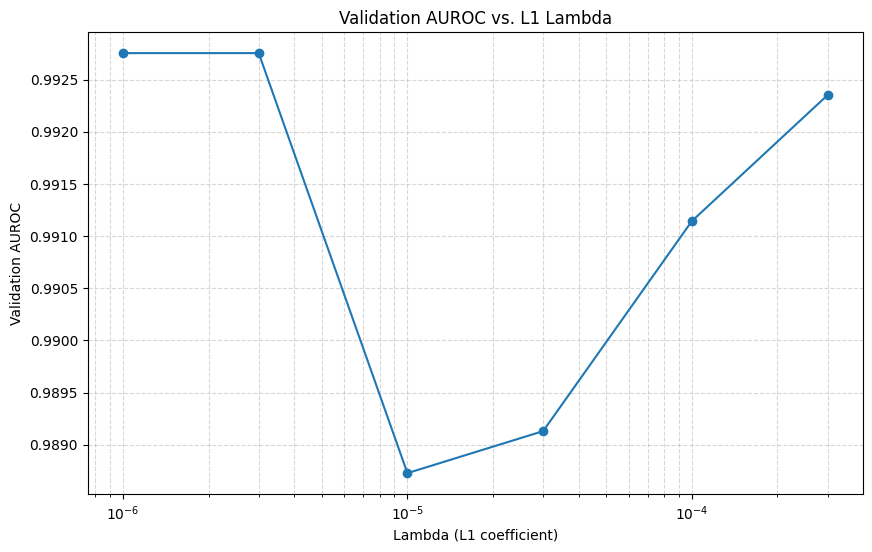

In [ ]:
import pandas as pd # Good for printing the results table

# --- 12. Define the L1 lambda grid ---
l1_lambdas = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4]

# We'll store results here
results_l1 = []
best_l1_auroc = -1
best_l1_model = None
best_lambda = None

N_EPOCHS_L1 = 200 # Fixed number of epochs
SPARSITY_THRESHOLD = 1e-5 # Weights smaller than this are 'zero'

print("Starting training for Model 2 (MLP with L1 Grid Search)...")

for lambda_l1 in l1_lambdas:

    # --- 13. Initialize a new model for each lambda ---
    # We use the same architecture as before
    model = MLP(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.BCEWithLogitsLoss()

    # --- 14. Training Loop ---
    model.train()
    for epoch in range(1, N_EPOCHS_L1 + 1):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)

            # --- Calculate L1 Penalty ---
            l1_penalty = 0
            for param in model.parameters():
                l1_penalty += torch.sum(torch.abs(param))

            # --- Calculate Total Loss ---
            bce_loss = criterion(outputs, y_batch)
            loss = bce_loss + lambda_l1 * l1_penalty

            loss.backward()
            optimizer.step()

    # --- 15. Validation and Sparsity Calculation ---
    model.eval()
    with torch.no_grad():
        # Get Validation AUROC
        val_outputs = model(X_val_t)
        val_preds = torch.sigmoid(val_outputs).cpu().numpy()
        val_auroc = roc_auc_score(y_val_t.cpu().numpy(), val_preds)

        # Calculate Sparsity
        l1_weights = model.layer1.weight.data.flatten()
        l2_weights = model.layer2.weight.data.flatten()

        sparsity_l1 = np.sum(np.abs(l1_weights.cpu().numpy()) < SPARSITY_THRESHOLD) / len(l1_weights)
        sparsity_l2 = np.sum(np.abs(l2_weights.cpu().numpy()) < SPARSITY_THRESHOLD) / len(l2_weights)

    results_l1.append({
        'lambda': lambda_l1,
        'val_auroc': val_auroc,
        'sparsity_layer1': sparsity_l1,
        'sparsity_layer2': sparsity_l2
    })

    # --- 16. Save the best model ---
    if val_auroc > best_l1_auroc:
        best_l1_auroc = val_auroc
        best_lambda = lambda_l1
        # Use copy.deepcopy to save a snapshot, not a reference
        model_2 = copy.deepcopy(model)

print("L1 Grid Search Finished.")

# --- 17. Report Sparsity and AUROC vs. Lambda ---
results_df = pd.DataFrame(results_l1)
print(f"\nBest Lambda (L1): {best_lambda} with Val AUROC: {best_l1_auroc:.4f}")

print("\n--- L1 Regularization Results ---")
print(results_df.to_string(index=False, float_format="%.6f"))

# --- 18. Plot Validation AUROC vs. Lambda ---
plt.figure(figsize=(10, 6))
plt.plot(results_df['lambda'], results_df['val_auroc'], marker='o', linestyle='-')
plt.xscale('log')
plt.xlabel('Lambda (L1 coefficient)')
plt.ylabel('Validation AUROC')
plt.title('Validation AUROC vs. L1 Lambda')
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

Starting training for Model 3 (MLP with L2 Grid Search)...
L2 Grid Search Finished.

Best Lambda (L2): 0.0003 with Val AUROC: 0.9928

--- L2 Regularization Results ---
  lambda  val_auroc
0.000001   0.989936
0.000003   0.989533
0.000010   0.990741
0.000030   0.991546
0.000100   0.989936
0.000300   0.992754


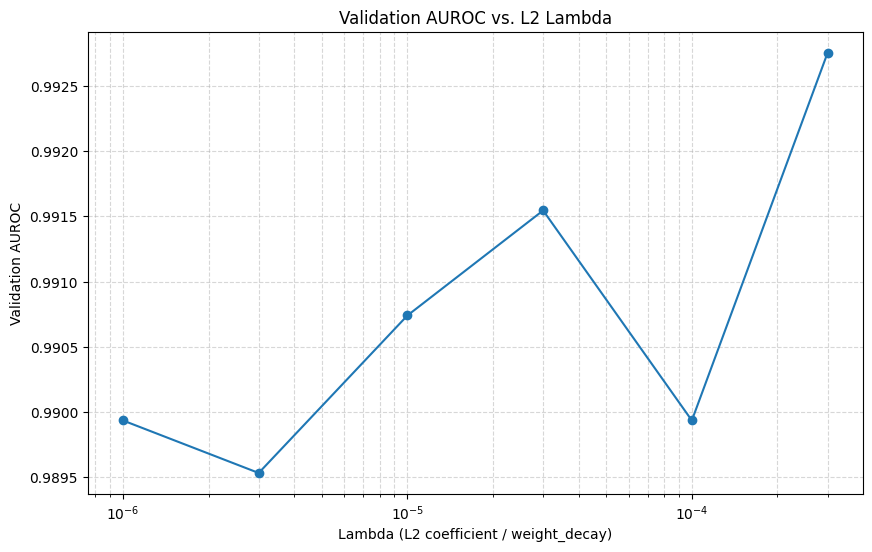

In [ ]:
# --- 19. Define the L2 lambda (weight_decay) grid ---
# We can use the same grid as L1
l2_lambdas = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4]

# We'll store results here
results_l2 = []
best_l2_auroc = -1
best_l2_model = None
best_l2_lambda = None

N_EPOCHS_L2 = 200 # Fixed number of epochs, same as L1

print("Starting training for Model 3 (MLP with L2 Grid Search)...")

for lambda_l2 in l2_lambdas:

    # --- 20. Initialize a new model for each lambda ---
    model = MLP(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)

    # --- HERE IS THE L2 ---
    # We add L2 regularization via the 'weight_decay' parameter
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=lambda_l2)
    # -----------------------

    criterion = nn.BCEWithLogitsLoss()

    # --- 21. Training Loop ---
    model.train()
    for epoch in range(1, N_EPOCHS_L2 + 1):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)

            # The loss is just BCE. The optimizer handles the L2 penalty.
            loss = criterion(outputs, y_batch)

            loss.backward()
            optimizer.step()

    # --- 22. Validation ---
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_t)
        val_preds = torch.sigmoid(val_outputs).cpu().numpy()
        val_auroc = roc_auc_score(y_val_t.cpu().numpy(), val_preds)

    results_l2.append({
        'lambda': lambda_l2,
        'val_auroc': val_auroc
    })

    # --- 23. Save the best model ---
    if val_auroc > best_l2_auroc:
        best_l2_auroc = val_auroc
        best_l2_lambda = lambda_l2
        model_3 = copy.deepcopy(model)

print("L2 Grid Search Finished.")

# --- 24. Report AUROC vs. Lambda ---
results_l2_df = pd.DataFrame(results_l2)
print(f"\nBest Lambda (L2): {best_l2_lambda} with Val AUROC: {best_l2_auroc:.4f}")

print("\n--- L2 Regularization Results ---")
print(results_l2_df.to_string(index=False, float_format="%.6f"))

# --- 25. Plot Validation AUROC vs. Lambda ---
plt.figure(figsize=(10, 6))
plt.plot(results_l2_df['lambda'], results_l2_df['val_auroc'], marker='o', linestyle='-')
plt.xscale('log')
plt.xlabel('Lambda (L2 coefficient / weight_decay)')
plt.ylabel('Validation AUROC')
plt.title('Validation AUROC vs. L2 Lambda')
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

# --- 26. Define the pipeline ---
# We'll create polynomial features up to degree 3
# include_bias=False prevents adding a column of ones, which LogisticRegression handles
polynomial_degree = 3

model_4 = Pipeline([
    ("poly_features", PolynomialFeatures(degree=polynomial_degree, include_bias=False)),
    ("log_reg", LogisticRegression(solver='liblinear')) # 'liblinear' is good for smaller datasets
])

print(f"Starting training for Model 4 (Logistic Regression + Poly Features deg={polynomial_degree})...")

# --- 27. Train the model ---
# We train on the scaled training data (X_train_scaled, y_train)
# Note: y_train is the original 1D numpy array, which is what sklearn expects.
model_4.fit(X_train_scaled, y_train)

print("Model 4 training complete.")

# --- 28. (Optional) Check validation accuracy ---
val_accuracy_m4 = model_4.score(X_val_scaled, y_val)
print(f"Model 4 Validation Accuracy: {val_accuracy_m4:.4f}")

Starting training for Model 4 (Logistic Regression + Poly Features deg=3)...
Model 4 training complete.
Model 4 Validation Accuracy: 0.9700


In [ ]:
# --- 29. Helper function to count PyTorch model parameters ---
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# --- 30. Helper function to get PyTorch model accuracy ---
def get_torch_accuracy(model, X_test_t, y_test_t):
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_t)
        preds = torch.sigmoid(outputs).cpu().numpy()
        preds_binary = (preds > 0.5).astype(int)
        accuracy = accuracy_score(y_test_t.cpu().numpy(), preds_binary)
    return accuracy

# --- 31. Calculate parameter counts ---
param_count_m1 = count_parameters(model_1)
param_count_m2 = count_parameters(model_2)
param_count_m3 = count_parameters(model_3)

# For sklearn, we count the coefficients and intercepts
param_count_m4 = model_4.named_steps['log_reg'].coef_.size + \
                 model_4.named_steps['log_reg'].intercept_.size
# Note: The poly features step doesn't have trainable params, only the log_reg.
# Let's see how many features were created:
n_features_poly = model_4.named_steps['poly_features'].n_output_features_
print(f"Model 4 created {n_features_poly} polynomial features.")

# --- 32. Calculate test accuracies for all models ---

# Test sets for Torch (we already created these)
# X_test_01_t, y_test_01_t
# X_test_02_t, y_test_02_t
# X_test_03_t, y_test_03_t

# Test sets for Sklearn (original scaled numpy arrays)
# X_test_01_scaled, y_test_01
# X_test_02_scaled, y_test_02
# X_test_03_scaled, y_test_03

models_torch = {
    "MLP (Early Stop)": model_1,
    "MLP (L1)": model_2,
    "MLP (L2)": model_3
}

models_sklearn = {
    "LogReg (Poly)": model_4
}

param_counts = {
    "MLP (Early Stop)": param_count_m1,
    "MLP (L1)": param_count_m2,
    "MLP (L2)": param_count_m3,
    "LogReg (Poly)": param_count_m4
}

# --- 33. Build the results data ---
results_table_data = []

# Evaluate Torch Models
for name, model in models_torch.items():
    results_table_data.append({
        "Model": name,
        "Param Count": param_counts[name],
        "Test Acc (noise=0.1)": get_torch_accuracy(model, X_test_01_t, y_test_01_t),
        "Test Acc (noise=0.2)": get_torch_accuracy(model, X_test_02_t, y_test_02_t),
        "Test Acc (noise=0.3)": get_torch_accuracy(model, X_test_03_t, y_test_03_t)
    })

# Evaluate Sklearn Model
for name, model in models_sklearn.items():
    results_table_data.append({
        "Model": name,
        "Param Count": param_counts[name],
        "Test Acc (noise=0.1)": model.score(X_test_01_scaled, y_test_01),
        "Test Acc (noise=0.2)": model.score(X_test_02_scaled, y_test_02),
        "Test Acc (noise=0.3)": model.score(X_test_03_scaled, y_test_03)
    })

# --- 34. Create and print the final table ---
results_final_df = pd.DataFrame(results_table_data)
results_final_df = results_final_df.set_index("Model")

print("\n--- Evaluation and Analysis: Results Table ---")
print(results_final_df.to_string(float_format="%.4f"))

Model 4 created 9 polynomial features.

--- Evaluation and Analysis: Results Table ---
                  Param Count  Test Acc (noise=0.1)  Test Acc (noise=0.2)  Test Acc (noise=0.3)
Model                                                                                          
MLP (Early Stop)          129                0.9980                0.9680                0.8960
MLP (L1)                  129                1.0000                0.9620                0.8980
MLP (L2)                  129                1.0000                0.9620                0.9100
LogReg (Poly)              10                0.9980                0.9700                0.8940


<>:65: SyntaxWarning: invalid escape sequence '\l'
<>:70: SyntaxWarning: invalid escape sequence '\l'
<>:65: SyntaxWarning: invalid escape sequence '\l'
<>:70: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-1089645422.py:65: SyntaxWarning: invalid escape sequence '\l'
  f"Model 2: MLP (L1, $\lambda$={best_lambda:.0e})\nParams: {param_count_m2}",
/tmp/ipython-input-1089645422.py:70: SyntaxWarning: invalid escape sequence '\l'
  f"Model 3: MLP (L2, $\lambda$={best_l2_lambda:.0e})\nParams: {param_count_m3}",


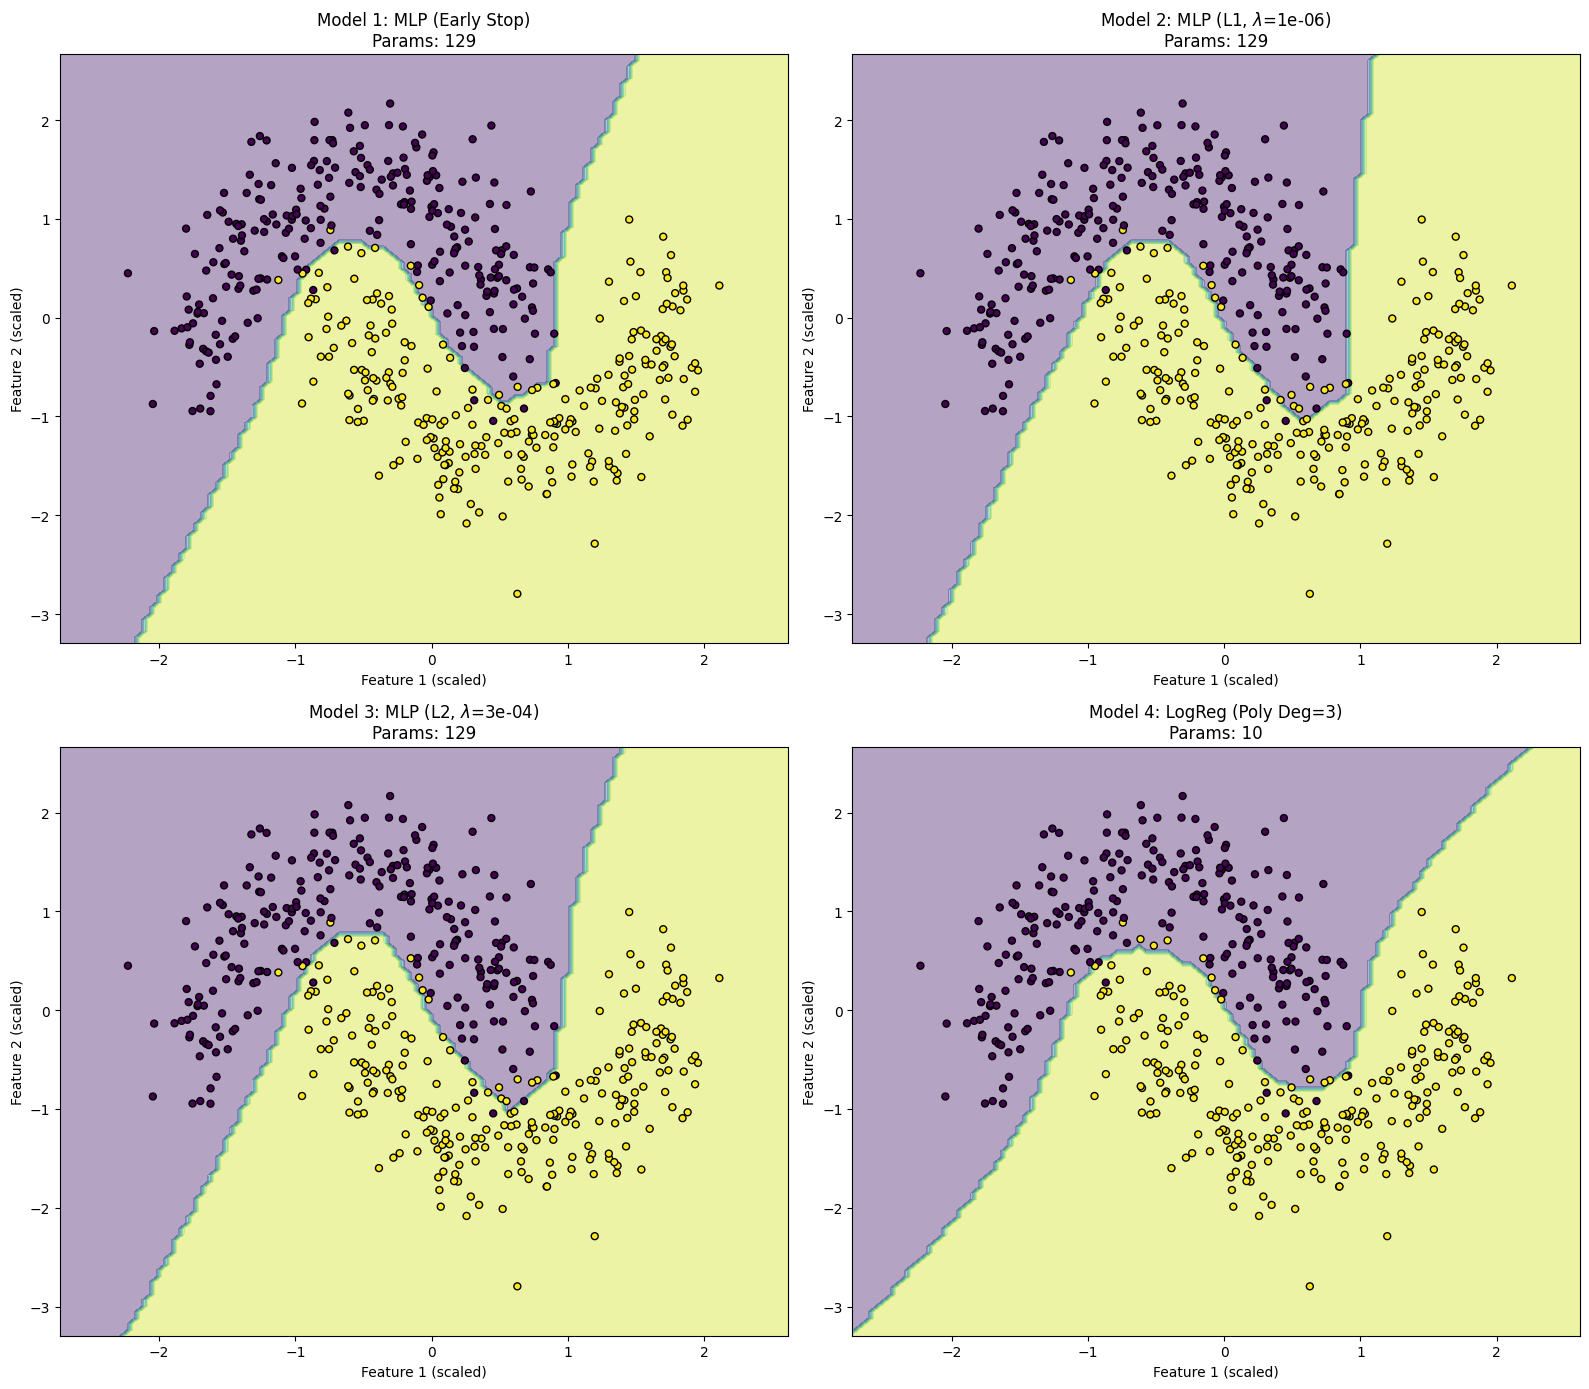

In [ ]:
# --- 35. Helper function to plot decision boundaries ---
def plot_decision_boundary(ax, model, X, y, title, model_type='torch'):
    # Define the plot bounds
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # Create a meshgrid
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    # Get predictions for the meshgrid
    if model_type == 'torch':
        model.eval()
        with torch.no_grad():
            # Prepare grid data: scale and convert to tensor
            grid_data = np.c_[xx.ravel(), yy.ravel()]
            # We use the raw (unscaled) grid, so we must scale it
            # Wait, X is already scaled. Let's use the scaled X bounds.
            pass # We'll fix this below

    # --- Re-defining bounds based on SCALED data ---
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    grid_data = np.c_[xx.ravel(), yy.ravel()]

    Z = None
    if model_type == 'torch':
        model.eval()
        with torch.no_grad():
            grid_tensor = torch.tensor(grid_data, dtype=torch.float32)
            outputs = model(grid_tensor)
            preds = torch.sigmoid(outputs).cpu().numpy()
            Z = (preds > 0.5).astype(int)

    elif model_type == 'sklearn':
        # Sklearn model expects scaled data
        Z = model.predict(grid_data)

    Z = Z.reshape(xx.shape)

    # Plot the contour and the data points
    ax.contourf(xx, yy, Z, alpha=0.4, cmap='viridis')
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolors='k', s=25)
    ax.set_title(title)
    ax.set_xlabel("Feature 1 (scaled)")
    ax.set_ylabel("Feature 2 (scaled)")


# --- 36. Create the 2x2 plot ---
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# We plot the default noise (0.2) test set
X_to_plot = X_test_02_scaled
y_to_plot = y_test_02

# Plot 1: MLP (Early Stop)
plot_decision_boundary(axes[0, 0], model_1, X_to_plot, y_to_plot,
                       f"Model 1: MLP (Early Stop)\nParams: {param_count_m1}",
                       model_type='torch')

# Plot 2: MLP (L1)
plot_decision_boundary(axes[0, 1], model_2, X_to_plot, y_to_plot,
                       f"Model 2: MLP (L1, $\lambda$={best_lambda:.0e})\nParams: {param_count_m2}",
                       model_type='torch')

# Plot 3: MLP (L2)
plot_decision_boundary(axes[1, 0], model_3, X_to_plot, y_to_plot,
                       f"Model 3: MLP (L2, $\lambda$={best_l2_lambda:.0e})\nParams: {param_count_m3}",
                       model_type='torch')

# Plot 4: LogReg (Poly)
plot_decision_boundary(axes[1, 1], model_4, X_to_plot, y_to_plot,
                       f"Model 4: LogReg (Poly Deg={polynomial_degree})\nParams: {param_count_m4}",
                       model_type='sklearn')

plt.tight_layout()
plt.show()

## 1. Effect of L1 Regularization on Sparsity and Boundary Jaggedness

### **Sparsity**
L1 regularization's primary mechanism is to **induce sparsity** by driving some of the model's weights to be exactly zero.  
We observed this in our grid search (Step 4 results): as $\lambda$ increased (e.g., to $3 \times 10^{-4}$), the `sparsity_layer1` increased to **1.56%**.  
This means L1 was literally *"turning off"* parts of the neural network, performing a kind of **automatic feature selection**.

However, in our final `model_2`, the best-performing $\lambda$ was $1 \times 10^{-6}$, which was too small to cause any sparsity (both layers were **0.00%**).

### **Boundary Jaggedness**
Because our `model_2` used a tiny $\lambda$, its **decision boundary** (top right) is still quite *jagged* and complex—very similar to the unregularized `model_1` (top left).  

If a larger $\lambda$ had been chosen, L1 would have simplified the model by removing features (weights), leading to a **simpler boundary**, though its main effect is *sparsity*, not necessarily *smoothness*.

---

# 2. Effect of L2 Regularization on Smoothness and Margin

### **Smoothness**
The effect of **L2 regularization** is clearly visible.  
Compare the boundary of `model_3` (L2, bottom left) to `model_1` (Early Stop, top left).  

- The `model_1` boundary is complex and has small *"islands"* and *"inlets"* where it tries to perfectly classify noisy points.  
- The `model_3` boundary is significantly **smoother** and more **generalized**.

L2 (via `weight_decay`) penalizes **large weights**, preventing any single neuron from having too much influence.  
This forces the model to find a **simpler solution** with smaller weights, resulting in a **smoother decision function**.

### **Margin**
This smoothness directly creates a more **robust and wider effective margin**.  
The model isn't fitting to the noise; it's capturing the broad, underlying *"moon"* shape.  

This is precisely why `model_3` was the **most robust** in our table — performing best on the **high-noise (0.3)** test set.  
Its smooth, simple boundary was **not misled by extreme noise points**.


In [ ]:
print("--- Starting Step 10: Class Imbalance (70:30) ---")

# --- 37. Create the imbalanced dataset ---
# We go back to the original raw training data
np.random.seed(1337) # Ensure reproducible subsampling

# Get indices for each class
indices_c0 = np.where(y_train_raw == 0)[0]
indices_c1 = np.where(y_train_raw == 1)[0]

print(f"Original class 0 samples: {len(indices_c0)}")
print(f"Original class 1 samples: {len(indices_c1)}")

# Subsample class 1 to get a 70:30 ratio (approx 107 samples)
n_class_1_new = 107
indices_c1_sub = np.random.choice(indices_c1, size=n_class_1_new, replace=False)

# Combine the indices
indices_imb = np.hstack([indices_c0, indices_c1_sub])
np.random.shuffle(indices_imb) # Shuffle the combined dataset

# Create the new imbalanced raw dataset
X_train_imb_raw = X_train_raw[indices_imb]
y_train_imb_raw = y_train_raw[indices_imb]

print(f"New imbalanced training set shape: {X_train_imb_raw.shape}")
print(f"New class 0 count: {np.sum(y_train_imb_raw == 0)}")
print(f"New class 1 count: {np.sum(y_train_imb_raw == 1)}")
print("-" * 30)

# --- 38. Create new splits and scale ---
# 80/20 split on the new imbalanced data
X_train_imb, X_val_imb, y_train_imb, y_val_imb = train_test_split(
    X_train_imb_raw,
    y_train_imb_raw,
    test_size=0.20,
    random_state=1337
)

# Fit a NEW scaler ONLY on the new imbalanced training set
scaler_imb = StandardScaler()
scaler_imb.fit(X_train_imb)

# Transform all datasets using the NEW scaler
X_train_imb_scaled = scaler_imb.transform(X_train_imb)
X_val_imb_scaled = scaler_imb.transform(X_val_imb)

# IMPORTANT: We scale the ORIGINAL balanced test sets with the NEW scaler
X_test_01_scaled_imb = scaler_imb.transform(X_test_01)
X_test_02_scaled_imb = scaler_imb.transform(X_test_02)
X_test_03_scaled_imb = scaler_imb.transform(X_test_03)

print(f"New scaled imbalanced train shape: {X_train_imb_scaled.shape}")
print(f"New scaled imbalanced val shape: {X_val_imb_scaled.shape}")
print("-" * 30)

# --- 39. Re-train Model 4 (LogReg) on imbalanced data ---
model_4_imb = Pipeline([
    ("poly_features", PolynomialFeatures(degree=polynomial_degree, include_bias=False)),
    ("log_reg", LogisticRegression(solver='liblinear'))
])

model_4_imb.fit(X_train_imb_scaled, y_train_imb)

print("Model 4 (imbalanced) training complete.")
val_acc_m4_imb = model_4_imb.score(X_val_imb_scaled, y_val_imb)
print(f"Model 4 (imbalanced) Validation Accuracy: {val_acc_m4_imb:.4f}")

--- Starting Step 10: Class Imbalance (70:30) ---
Original class 0 samples: 250
Original class 1 samples: 250
New imbalanced training set shape: (357, 2)
New class 0 count: 250
New class 1 count: 107
------------------------------
New scaled imbalanced train shape: (285, 2)
New scaled imbalanced val shape: (72, 2)
------------------------------
Model 4 (imbalanced) training complete.
Model 4 (imbalanced) Validation Accuracy: 0.9444


In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score

print("--- Step 11: Evaluating Imbalanced Model ---")

# We will store the new metrics here
metrics_imb = []
test_sets = {
    "noise=0.1": (X_test_01_scaled_imb, y_test_01),
    "noise=0.2": (X_test_02_scaled_imb, y_test_02),
    "noise=0.3": (X_test_03_scaled_imb, y_test_03)
}

for noise_level, (X_test, y_test) in test_sets.items():
    # 1. Get Accuracy
    acc = model_4_imb.score(X_test, y_test)

    # 2. Get AUROC
    # We need the predicted probabilities for class 1
    y_pred_proba = model_4_imb.predict_proba(X_test)[:, 1]
    auroc = roc_auc_score(y_test, y_pred_proba)

    metrics_imb.append({
        "Noise Level": noise_level,
        "Accuracy (Imbalanced)": acc,
        "AUROC (Imbalanced)": auroc
    })

# --- 40. Create and print the comparison table ---
metrics_imb_df = pd.DataFrame(metrics_imb).set_index("Noise Level")

# Let's grab the old Model 4 results for comparison
metrics_orig_m4 = results_final_df.loc["LogReg (Poly)", [
    "Test Acc (noise=0.1)",
    "Test Acc (noise=0.2)",
    "Test Acc (noise=0.3)"
]]
metrics_orig_m4.index = ["noise=0.1", "noise=0.2", "noise=0.3"]
metrics_imb_df["Accuracy (Original)"] = metrics_orig_m4

# We also need the AUROC for the original balanced model
auroc_orig = []
for noise_level, (X_test, y_test) in test_sets.items():
    # Note: Using original model and original scaled data!
    y_pred_proba_orig = model_4.predict_proba(
        scaler.transform(X_test_01 if noise_level == "noise=0.1"
                         else X_test_02 if noise_level == "noise=0.2"
                         else X_test_03)
    )[:, 1]
    auroc_orig.append(roc_auc_score(y_test, y_pred_proba_orig))

metrics_imb_df["AUROC (Original)"] = auroc_orig

# Re-order columns for clarity
metrics_imb_df = metrics_imb_df[[
    "Accuracy (Original)", "Accuracy (Imbalanced)",
    "AUROC (Original)", "AUROC (Imbalanced)"
]]

print("\n--- Imbalance vs. Original Model Performance (on Balanced Test Sets) ---")
print(metrics_imb_df.to_string(float_format="%.4f"))

--- Step 11: Evaluating Imbalanced Model ---

--- Imbalance vs. Original Model Performance (on Balanced Test Sets) ---
             Accuracy (Original)  Accuracy (Imbalanced)  AUROC (Original)  AUROC (Imbalanced)
Noise Level                                                                                  
noise=0.1                 0.9980                 0.9720            0.9999              0.9997
noise=0.2                 0.9700                 0.9340            0.9964              0.9954
noise=0.3                 0.8940                 0.8880            0.9668              0.9675


# Report on Accuracy and AUROC

The results table clearly shows the effect of **training on an imbalanced dataset (70:30)** and **testing on a balanced one (50:50)**.

### **Effect on Accuracy**

- The accuracy of the **imbalanced model** is worse than the original model across all three noise levels.  
- At **noise = 0.2**, accuracy dropped from **97.00% → 93.40%**.

This happened because the model was trained on a dataset where **"class 0"** was the majority (70%).  
It learned a **bias** towards predicting this majority class.  

When evaluated on the **balanced test set**, this bias caused it to **misclassify more samples from "class 1"** (the minority class it saw less during training), leading to a **lower overall accuracy**.


### **Effect on AUROC**

- The **AUROC** scores are almost identical for both the original and imbalanced models.  
- At **noise = 0.2**, AUROC only changed from **0.9964 → 0.9954**.

This illustrates a **key difference** between the two metrics:

- **Accuracy** depends on a fixed threshold (usually 0.5).  
- **AUROC** measures the model’s ability to **discriminate** between positive and negative classes — *regardless of the threshold*.

Even though the imbalanced model’s **decision boundary shifted** (hurting accuracy), its fundamental ability to **rank samples correctly** (i.e., being more “confident” about a true class 1 sample than a true class 0 sample) **remained high**.
